# 02 - Syllable Duration Entropy: Mature vs. Juvenile

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import avn.dataloading as dataloading
import avn.segmentation
import avn.syntax as syntax
import matplotlib.pyplot as plt
from scipy.stats import entropy
import glob

In [2]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_file']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

## Adult Bird Data

In [3]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434",  "Y433", "Y453"] 

#All_Birds should contain 35 bird IDs. Check: 
len(All_Birds)

35

In [5]:
w_all_shan = pd.DataFrame()
for Bird_ID in All_Birds:

    #load wseg segmentations
    wseg_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
    wseg_segments = pd.read_csv(wseg_path).rename(columns = {'onset' : 'onsets', 
                                                             'offset' : 'offsets', 
                                                             'file' : 'files'})
    wseg_data = avn.segmentation.SegData(Bird_ID, wseg_segments)
    wseg_data.seg_table["Syll_dur"] = (wseg_data.seg_table.offsets - wseg_data.seg_table.onsets)*1000
    wseg_data.seg_table['method'] = "Whisper Segmentation"

    bins = np.linspace(-2.5, 0, 50)
    density, __ = np.histogram(np.log10(wseg_data.seg_table.Syll_dur / 1000), density=True, bins = bins)
    wseg_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'entropy_wseg' : [wseg_entropy], 
                             "Bird_ID" : Bird_ID})
    
    w_all_shan = pd.concat([w_all_shan, curr_shan])

In [6]:
all_birds = pd.read_csv("D:\\Final_Bird_Dataset\\old_Bird_list.csv")
w_all_shan = pd.merge(w_all_shan, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

group_dict = {'Isolate' : 'Isolate Adult', 
              'GFP' : 'Typical Adult', 
              'FP1_KD_pre_tut' : 'FP1 KD Adult', 
              'FP1_KD_post_tut' : 'Typical Adult'}
w_all_shan['Group'] = [group_dict[x] for x in w_all_shan.Condition]

In [ ]:
w_all_shan.head(3)

,entropy_wseg,Bird_ID,Condition,Group
0,0.631623,B145,Isolate,Isolate Adult
1,0.731460,B236,Isolate,Isolate Adult
2,0.511742,B258,Isolate,Isolate Adult


## Juvenile Bird Data

In [7]:
all_birds = glob.glob('D:\\Juveniles\\Single_day_per_juvenile\\*')
all_birds = [x.split('\\')[-1] for x in all_birds]
all_birds

['Y855_51',
 'S856_51',
 'Y856_50',
 'S855_51',
 'S833_51',
 'O833_51',
 'notag833_51',
 'O883_51',
 'R833_51',
 'O472_50',
 'Y472_50']

In [8]:
len(all_birds)

11

In [9]:
juv_all_shan = pd.DataFrame()
for Bird_ID in all_birds:

    #load wseg segmentations
    wseg_path = 'D:\\Juveniles\\WhisperSeg_segmentations\\' + Bird_ID +  '_wseg.csv'
    wseg_segments = pd.read_csv(wseg_path).rename(columns = {'onset' : 'onsets', 
                                                             'offset' : 'offsets', 
                                                             'file' : 'files'})
    wseg_data = avn.segmentation.SegData(Bird_ID, wseg_segments)
    wseg_data.seg_table["Syll_dur"] = (wseg_data.seg_table.offsets - wseg_data.seg_table.onsets)*1000
    wseg_data.seg_table['method'] = "Whisper Segmentation"

    bins = np.linspace(-2.5, 0, 50)
    density, __ = np.histogram(np.log10(wseg_data.seg_table.Syll_dur / 1000), density=True, bins = bins)
    wseg_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'entropy_wseg' : [wseg_entropy], 
                             "Bird_ID" : Bird_ID})
    
    juv_all_shan = pd.concat([juv_all_shan, curr_shan])

In [10]:
juv_all_shan['Group'] = 'Juvenile'

## Compare Groups

In [11]:
all_shan = pd.concat([w_all_shan[['Bird_ID', 'Group', 'entropy_wseg']], juv_all_shan])

In [14]:
all_shan.to_csv('syllable_duration_entropies.csv')

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
all_shan = pd.read_csv('syllable_duration_entropies.csv')

In [14]:
all_shan.head(3)

,Unnamed: 0,Bird_ID,Group,entropy_wseg
0,0,B145,Isolate Adult,0.631623
1,1,B236,Isolate Adult,0.731460
2,2,B258,Isolate Adult,0.511742


In [15]:
all_shan.Group = all_shan.Group.astype('category').cat.set_categories(['Typical Adult', 'Isolate Adult', 'FP1 KD Adult', 'Juvenile'], ordered = True)

(0.4, 0.9)

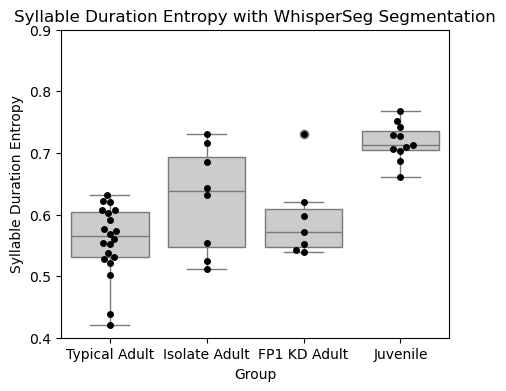

In [16]:
plt.figure(figsize = (5, 4))
sns.boxplot(data = all_shan, x = 'Group', y = 'entropy_wseg', color = '0.8')
sns.swarmplot(data = all_shan, x = 'Group', y = 'entropy_wseg', color = 'black', s = 5)
plt.ylabel('Syllable Duration Entropy')
plt.title('Syllable Duration Entropy with WhisperSeg Segmentation')
plt.ylim(0.4, 0.9)

In [17]:
plt.rcParams.update({'font.size': 8})

In [18]:
palette = sns.color_palette([sns.color_palette()[1], sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4]])
palette

[(1.0, 0.4980392156862745, 0.054901960784313725),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353)]

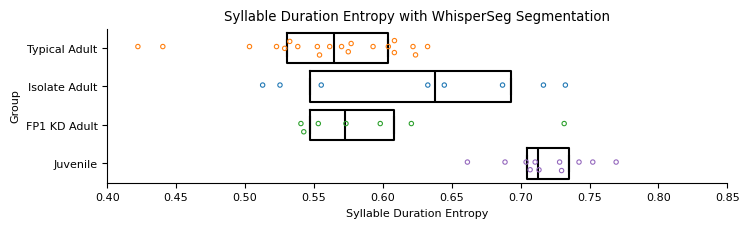

In [25]:
plt.figure(figsize = (8, 2))
sns.boxplot(data = all_shan, y = 'Group', x = 'entropy_wseg', color = 'black', fill = None, fliersize=0, whis = 0, )
sns.swarmplot(data = all_shan, y = 'Group', x= 'entropy_wseg', hue = 'Group', s = 6, palette= palette, marker = '$\circ$')
plt.xlabel('Syllable Duration Entropy')
plt.title('Syllable Duration Entropy with WhisperSeg Segmentation')
plt.xlim(0.4, 0.85)
sns.despine()
plt.savefig('syllable_duration_entropy_across_groups.svg', transparent = True)

In [30]:
plt.rcParams.update({'font.size': 12})

In [28]:
all_shan.Group = all_shan.Group.cat.rename_categories({'Isolate Adult' : 'Isolate\nAdult',
                                                       'Typical Adult' : 'Typical\nAdult', 
                                                       'FP1 KD Adult' : 'FP1 KD\nAdult', 
                                                       'Juvenile' : 'Juvenile'})

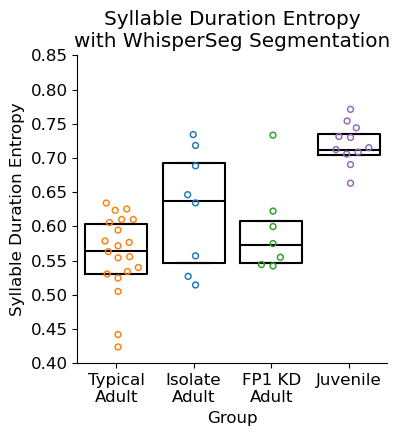

In [33]:
plt.figure(figsize = (4, 4))
sns.boxplot(data = all_shan, x = 'Group', y = 'entropy_wseg', color = 'black', fill = None, fliersize=0, whis = 0, )
sns.swarmplot(data = all_shan, x = 'Group', y= 'entropy_wseg', hue = 'Group', s = 8, palette= palette, marker = '$\circ$')
plt.ylabel('Syllable Duration Entropy')
plt.title('Syllable Duration Entropy\nwith WhisperSeg Segmentation')
plt.ylim(0.4, 0.85)
sns.despine()

In [6]:
isolates_AVN = all_shan.entropy_wseg[all_shan.Group== 'Isolate Adult']
normal_AVN = all_shan.entropy_wseg[all_shan.Group == 'Typical Adult']
FP1_AVN = all_shan.entropy_wseg[all_shan.Group == 'FP1 KD Adult']
juvenile_AVN = all_shan.entropy_wseg[all_shan.Group == 'Juvenile']

In [7]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [8]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN, juvenile_AVN)
print(fvalue, pvalue)

17.43730336859831 1.672158640251834e-07


In [9]:
tukey = pairwise_tukeyhsd(endog = all_shan['entropy_wseg'], 
                          groups = all_shan['Group'], 
                          alpha = 0.05)

print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
 FP1 KD Adult Isolate Adult   0.0315 0.7382 -0.0511  0.1142  False
 FP1 KD Adult      Juvenile   0.1245 0.0005  0.0473  0.2017   True
 FP1 KD Adult Typical Adult  -0.0358 0.5272 -0.1059  0.0343  False
Isolate Adult      Juvenile    0.093 0.0089  0.0188  0.1672   True
Isolate Adult Typical Adult  -0.0673 0.0475 -0.1341 -0.0006   True
     Juvenile Typical Adult  -0.1603    0.0 -0.2203 -0.1004   True
------------------------------------------------------------------


# Gaps

## Adult Bird Data

In [31]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "Y433", "Y453"] 

#All_Birds should contain 36 bird IDs. Check: 
len(All_Birds)

35

In [32]:
bin_dur = 10

In [33]:
w_all_shan_gap = pd.DataFrame()
for Bird_ID in All_Birds:

    #load whisper-seg predictions
    segmentations_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
    predictions_wseg = pd.read_csv(segmentations_path)
    predictions_reformat = predictions_wseg.rename(columns = {'onset' : 'onsets', 
                                                'offset' : 'offsets',
                                                'file' : 'files'})

    predictions_reformat['labels'] = 's'
    
    song_folder_path = 'D:\\Final_Bird_Dataset\\FP1_project_birds\\segmented_songs\\' 

    syntax_data = syntax.SyntaxData(Bird_ID, predictions_reformat)
    syntax_data.add_file_bounds(song_folder_path)
    gaps_df = syntax_data.get_gaps_df()

    #select only gaps less than 200ms, as longer likely reflect inter-motif gaps
    gaps_df = gaps_df[gaps_df.durations < 0.2]
    #convert from s to ms
    gaps_df.durations = gaps_df.durations*1000

    bins = np.arange(0, 200, bin_dur)
    density, __ = np.histogram(gaps_df.durations, density=True, bins = bins)
    gap_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'wseg_gap_duration_entropy' : [gap_entropy],
                             "Bird_ID" : Bird_ID})
    
    w_all_shan_gap = pd.concat([w_all_shan_gap, curr_shan])

In [34]:
all_birds = pd.read_csv("D:\\Final_Bird_Dataset\\old_Bird_list.csv")
w_all_shan_gap = pd.merge(w_all_shan_gap, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

group_dict = {'Isolate' : 'Isolate Adult', 
              'GFP' : 'Typical Adult', 
              'FP1_KD_pre_tut' : 'FP1 KD Adult', 
              'FP1_KD_post_tut' : 'Typical Adult'}
w_all_shan_gap['Group'] = [group_dict[x] for x in w_all_shan_gap.Condition]

In [35]:
w_all_shan_gap.head(3)

,wseg_gap_duration_entropy,Bird_ID,Condition,Group
0,0.650696,B145,Isolate,Isolate Adult
1,0.890905,B236,Isolate,Isolate Adult
2,0.726944,B258,Isolate,Isolate Adult


## Juvenile Bird Data

In [36]:
all_birds = glob.glob('D:\\Juveniles\\Single_day_per_juvenile\\*')
all_birds = [x.split('\\')[-1] for x in all_birds]
all_birds

['Y855_51',
 'S856_51',
 'Y856_50',
 'S855_51',
 'S833_51',
 'O833_51',
 'notag833_51',
 'O883_51',
 'R833_51',
 'O472_50',
 'Y472_50']

In [37]:
len(all_birds)

11

In [38]:
juv_all_shan_gap = pd.DataFrame()
for Bird_ID in all_birds:

    #load wseg segmentations
    wseg_path = 'D:\\Juveniles\\WhisperSeg_segmentations\\' + Bird_ID +  '_wseg.csv'

    #load whisper-seg predictions
    segmentations_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
    predictions_wseg = pd.read_csv(wseg_path)
    predictions_reformat = predictions_wseg.rename(columns = {'onset' : 'onsets', 
                                                'offset' : 'offsets',
                                                'file' : 'files'})

    predictions_reformat['labels'] = 's'
    
    song_folder_path = 'D:\\Juveniles\\Single_day_per_juvenile\\'

    syntax_data = syntax.SyntaxData(Bird_ID, predictions_reformat)
    syntax_data.add_file_bounds(song_folder_path)
    gaps_df = syntax_data.get_gaps_df()

    #select only gaps less than 200ms, as longer likely reflect inter-motif gaps
    gaps_df = gaps_df[gaps_df.durations < 0.2]
    #convert from s to ms
    gaps_df.durations = gaps_df.durations*1000

    bins = np.arange(0, 200, bin_dur)
    density, __ = np.histogram(gaps_df.durations, density=True, bins = bins)
    gap_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'wseg_gap_duration_entropy' : [gap_entropy],
                             "Bird_ID" : Bird_ID})
    
    juv_all_shan_gap = pd.concat([juv_all_shan_gap, curr_shan])

In [14]:
juv_all_shan_gap['Group'] = 'Juvenile'

## Compare Groups

In [15]:
all_shan = pd.concat([w_all_shan_gap[['Bird_ID', 'Group', 'wseg_gap_duration_entropy']], juv_all_shan_gap])

In [16]:
all_shan.to_csv('gap_duration_entropies.csv')

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
all_shan = pd.read_csv('gap_duration_entropies.csv')

In [41]:
all_shan.head(3)

,Unnamed: 0,Bird_ID,Group,wseg_gap_duration_entropy
0,0,B145,Isolate Adult,0.650696
1,1,B236,Isolate Adult,0.890905
2,2,B258,Isolate Adult,0.726944


In [42]:
all_shan.Group = all_shan.Group.astype('category').cat.set_categories(['Typical Adult', 'Isolate Adult', 'FP1 KD Adult', 'Juvenile'], ordered = True)

(0.53, 1.0)

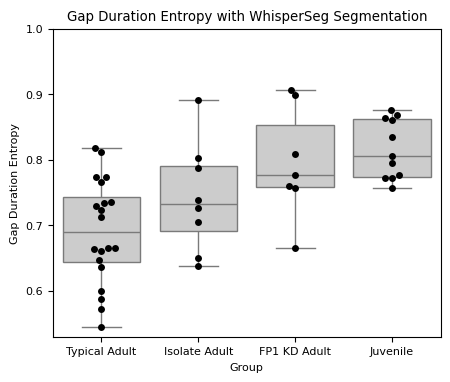

In [43]:
plt.figure(figsize = (5, 4))
sns.boxplot(data = all_shan, x = 'Group', y = 'wseg_gap_duration_entropy', color = '0.8')
sns.swarmplot(data = all_shan, x = 'Group', y = 'wseg_gap_duration_entropy', color = 'black', s = 5)
plt.ylabel('Gap Duration Entropy')
plt.title('Gap Duration Entropy with WhisperSeg Segmentation')
plt.ylim(0.53, 1)

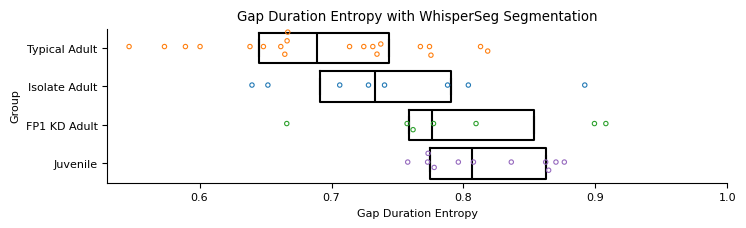

In [46]:
plt.figure(figsize = (8, 2))
sns.boxplot(data = all_shan, y = 'Group', x = 'wseg_gap_duration_entropy', color = 'black', fill = None, fliersize=0, whis = 0, )
sns.swarmplot(data = all_shan, y = 'Group', x= 'wseg_gap_duration_entropy', hue = 'Group', s = 6, palette= palette, marker = '$\circ$')
plt.xlabel('Gap Duration Entropy')
plt.title('Gap Duration Entropy with WhisperSeg Segmentation')
plt.xlim(0.53, 1)
sns.despine()
plt.savefig('gap_duration_entropy_across_groups.svg', transparent = True)

In [7]:
isolates_AVN = all_shan.wseg_gap_duration_entropy[all_shan.Group== 'Isolate Adult']
normal_AVN = all_shan.wseg_gap_duration_entropy[all_shan.Group == 'Typical Adult']
FP1_AVN = all_shan.wseg_gap_duration_entropy[all_shan.Group == 'FP1 KD Adult']
juvenile_AVN = all_shan.wseg_gap_duration_entropy[all_shan.Group == 'Juvenile']

In [8]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [9]:
fvalue, pvalue = f_oneway(isolates_AVN, normal_AVN, FP1_AVN, juvenile_AVN)
print(fvalue, pvalue)

8.032705079040523 0.0002413584798944532


In [10]:
tukey = pairwise_tukeyhsd(endog = all_shan['wseg_gap_duration_entropy'], 
                          groups = all_shan['Group'], 
                          alpha = 0.05)

print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
 FP1 KD Adult Isolate Adult  -0.0533 0.5128 -0.1561  0.0494  False
 FP1 KD Adult      Juvenile   0.0207 0.9385 -0.0753  0.1166  False
 FP1 KD Adult Typical Adult  -0.1048 0.0128 -0.1919 -0.0177   True
Isolate Adult      Juvenile    0.074 0.1549 -0.0182  0.1663  False
Isolate Adult Typical Adult  -0.0515 0.3583 -0.1345  0.0316  False
     Juvenile Typical Adult  -0.1255 0.0003    -0.2  -0.051   True
------------------------------------------------------------------
